In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [100]:
import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import math
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [9]:
data = '/content/drive/MyDrive/trajectories_imu/df_RGC.pkl'
with open(data, 'rb') as file:
    data = pickle.load(file)

label = '/content/drive/MyDrive/trajectories_imu/labels_RGC.pkl'
with open(label, 'rb') as file:
    labels = pickle.load(file)

labels = labels.values
umbral = 50

# Transformació per obtenir labels one-hot encoded
labels_one_hot = np.array([[1, 0] if label < umbral else [0, 1] for label in labels])

# [1 0] = mostra positiva, [0 1] = mostra negativa
# classe 0 = mostra positiva, classe 1 = mostra negativa

In [10]:
print(data.shape,len(labels))

(102, 3, 1127) 102


In [102]:
"""def f1_metric(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return f1_score(y_true, y_pred, zero_division=1)"""
# Definir función para calcular F1-score
def f1_metric(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(tf.equal(y_pred, 1), tf.float32))
    actual_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), tf.float32))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1


In [105]:
def build_model(lr=0.001, units_gru=64, units_gru_2=32, units_dense=16):
    model = tf.keras.Sequential()

    # Capa GRU 1 para procesar las secuencias temporales
    model.add(layers.GRU(units_gru, return_sequences=True, input_shape=(data.shape[1], data.shape[2])))

    # Capa GRU 2 para capturar características a diferentes escalas
    model.add(layers.GRU(units_gru_2, return_sequences=False))

    # Capa totalmente conectada para procesar características a nivel de píxeles
    model.add(layers.Dense(units_dense, activation='relu'))  # Usamos ReLU en lugar de ReLU

    # Capa totalmente conectada final con función de activación sigmoide para clasificación binaria
    model.add(layers.Dense(2, activation='softmax'))  # Usamos softmax con 2 unidades para clasificación binaria

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[f1_metric])

    return model

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

def create_dataloader(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    return dataset

(81, 2) (21, 2)


# HYPERPARAMETER TUNNING

In [107]:
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'units_gru': [32, 64, 128],
    'units_gru_2': [16, 32, 64],
    'units_dense': [8, 16, 32]
}

# Usar KerasClassifier para clasificación binaria
keras_model = KerasClassifier(build_fn=build_model, verbose=0)
#keras_model = KerasRegressor(build_fn=build_model, verbose=0) #especificar el constructor del model + si volem imprimir el progres de l'entrenament

#cross-validation
grid_search = RandomizedSearchCV (keras_model, param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

<ipython-input-107-463d8d8e9c26>:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=build_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 335, in score
    raise ValueError(
ValueError: The model is not configu

In [108]:
#evaluacio del model amb els millor hyperparametres
best_model = grid_result.best_estimator_.model
test_loss, test_f1 = best_model.evaluate(X_test, y_test)
print("\nLoss al conjunt de prova:", test_loss)
print("F1-score l conjunt de prova:", test_f1)

1/1 [==============================] - 1s 1s/step - loss: 0.6595 - f1_metric: 0.8000

Loss al conjunt de prova: 0.6595059633255005
F1-score l conjunt de prova: 0.800000011920929


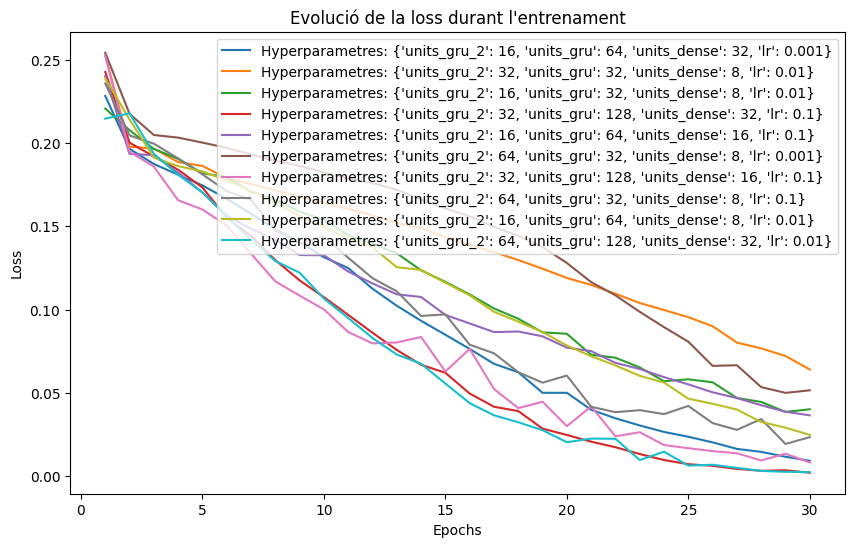

In [109]:
# Obtenir l'historial d'entrenament per a cada model en la cerca d'hyperparàmetres
loss_history = []
for params, cv_results in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score']):
    model = build_model(**params)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[f1_metric])
    history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=0)
    loss_history.append(history.history['loss'])

plt.figure(figsize=(10, 6))
for i, loss in enumerate(loss_history):
    plt.plot(range(1, len(loss)+1), loss, label=f"Hyperparametres: {grid_result.cv_results_['params'][i]}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la loss durant l\'entrenament')
plt.legend()
plt.show()

In [110]:
print("Millors hyperparàmetres:")
print(grid_result.best_params_)

print("\nMillor score:")
print(grid_result.best_score_)

Millors hyperparàmetres:
{'units_gru_2': 16, 'units_gru': 64, 'units_dense': 32, 'lr': 0.001}

Millor score:
nan


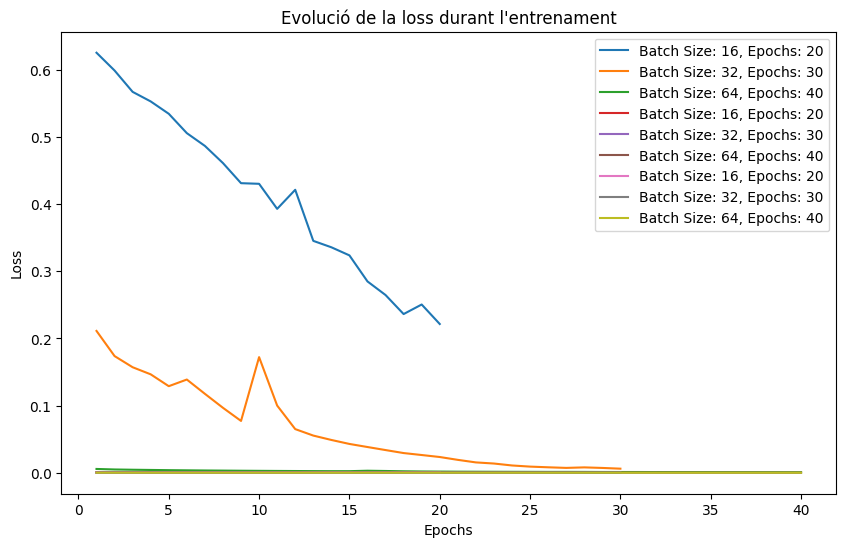

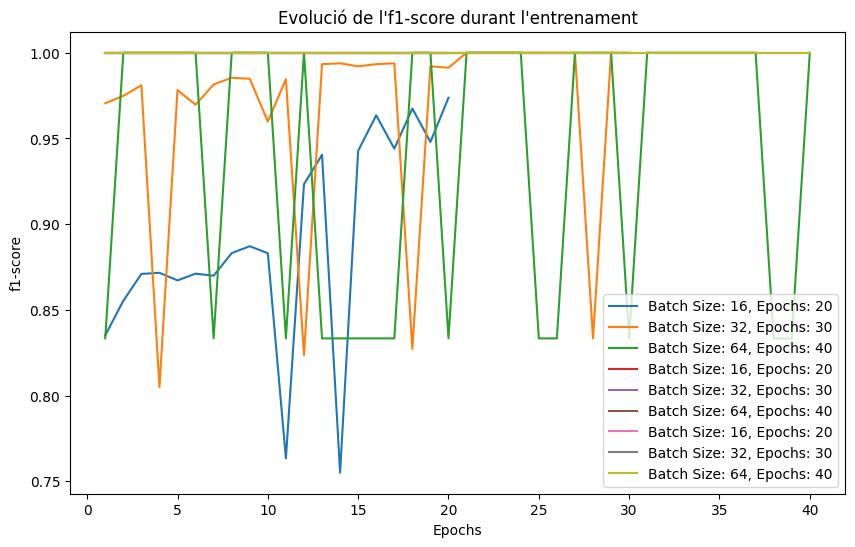

In [111]:
# Emmagatzemar els hyperparàmetres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)

#Diferents valors a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

loss_values = []
mae_values = []

for batch_size in batch_sizes:
    for epochs in epochs_values:
        train_dataset = create_dataloader(X_train, y_train, batch_size)
        history = model.fit(train_dataset, epochs=epochs, verbose=0)

        loss_values.append(history.history['loss'])
        mae_values.append(history.history['f1_metric'])

#Graficar l'evolució de les proves (loss)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(loss_values[i])+1), loss_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la loss durant l\'entrenament')
plt.legend()
plt.show()

#Graficar l'evolució de les proves (f1)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(mae_values[i])+1), mae_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.title('Evolució de l\'f1-score durant l\'entrenament')
plt.legend()
plt.show()


In [112]:
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

best_f1 = float('inf')
best_batch_size = None
best_epochs = None

# Emmagatzemar els hyperparàmetres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']

# Cerca d'hyperparàmetres
for batch_size in batch_sizes:
    for epochs in epochs_values:
        model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

        _, test_f1 = model.evaluate(X_test, y_test, verbose=0)

        if test_f1 < best_f1:
            best_f1 = test_f1
            best_batch_size = batch_size
            best_epochs = epochs

print("Millor combinació d'hyperparàmetres:")
print("Batch size:", best_batch_size)
print("Epochs:", best_epochs)
print("f1-score al conjunt de prova:", best_f1)

Millor combinacií d'hyperparàmetres:
Batch size: 64
Epochs: 40
f1-score al conjunt de prova: 0.6399999260902405


# Model final

In [113]:
#hyperparametres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
batch_size = best_batch_size

#creació i compilació model
final_model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)

# Creació del DataLoader
train_dataset = create_dataloader(X_train, y_train, batch_size)

#entrenament del model amb els hyperparametres trobats
final_model.fit(train_dataset, epochs=best_epochs, verbose=1)

#Evaluació amb el conjunt test
test_dataset = create_dataloader(X_test, y_test, batch_size)
test_loss, test_f1 = final_model.evaluate(test_dataset, verbose=0)
print(f"Loss al conjunt de prova: {test_loss}")
print(f"f1-score al conjunt de prova: {test_f1}")

Epoch 1/40
2/2 [==============================] - 4s 17ms/step - loss: 0.6903 - f1_metric: 0.7099
Epoch 2/40
2/2 [==============================] - 0s 16ms/step - loss: 0.5973 - f1_metric: 0.8372
Epoch 3/40
2/2 [==============================] - 0s 19ms/step - loss: 0.5876 - f1_metric: 0.8372
Epoch 4/40
2/2 [==============================] - 0s 17ms/step - loss: 0.5643 - f1_metric: 0.8372
Epoch 5/40
2/2 [==============================] - 0s 16ms/step - loss: 0.5474 - f1_metric: 0.8645
Epoch 6/40
2/2 [==============================] - 0s 17ms/step - loss: 0.5317 - f1_metric: 0.8214
Epoch 7/40
2/2 [==============================] - 0s 24ms/step - loss: 0.5169 - f1_metric: 0.8515
Epoch 8/40
2/2 [==============================] - 0s 19ms/step - loss: 0.4976 - f1_metric: 0.8762
Epoch 9/40
2/2 [==============================] - 0s 17ms/step - loss: 0.4765 - f1_metric: 0.8520
Epoch 10/40
2/2 [==============================] - 0s 17ms/step - loss: 0.4611 - f1_metric: 0.8450
Epoch 11/40
2/2 [==

In [114]:
y_pred = final_model.predict(X_test)
for i in range(len(y_test)):
  print(y_test[i],"    ",y_pred[i])

1/1 [==============================] - 1s 1s/step
[1 0]      [0.18000573 0.81999415]
[0 1]      [0.39780974 0.60219026]
[0 1]      [0.90345865 0.09654123]
[0 1]      [0.00705948 0.99294055]
[0 1]      [0.96228343 0.03771652]
[0 1]      [0.96286404 0.03713584]
[1 0]      [0.02700246 0.97299755]
[0 1]      [0.60478866 0.39521128]
[0 1]      [0.9660705  0.03392947]
[1 0]      [0.18142714 0.81857276]
[0 1]      [0.01010725 0.9898928 ]
[1 0]      [0.18000573 0.81999415]
[0 1]      [0.00485028 0.9951498 ]
[0 1]      [0.00613766 0.9938624 ]
[0 1]      [0.16917892 0.8308211 ]
[0 1]      [0.07064676 0.9293532 ]
[0 1]      [0.014034 0.985966]
[1 0]      [0.7219872  0.27801284]
[1 0]      [0.39122576 0.60877424]
[1 0]      [0.03723974 0.96276027]
[0 1]      [0.4493324  0.55066764]


In [115]:
# Convertir les probabilitats en one-hot enoded vectors
preds_one_hot = np.argmax(y_pred, axis=1)
preds_one_hot_encoded = tf.keras.utils.to_categorical(preds_one_hot, num_classes=2)
y_test_one_hot = np.argmax(y_test, axis=1)

# Visualització resultats

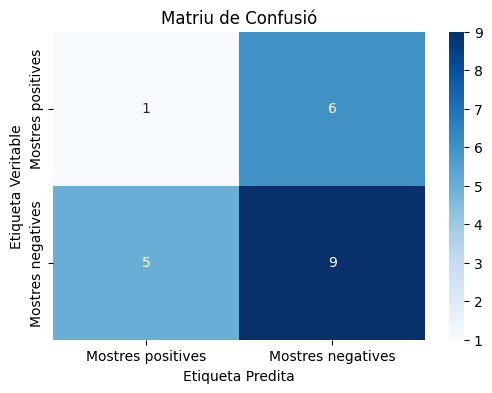

In [116]:
cm = confusion_matrix(y_test_one_hot, preds_one_hot)

clases = ['Mostres positives', 'Mostres negatives']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)

plt.xlabel('Etiqueta Predita')
plt.ylabel('Etiqueta Veritable')
plt.title('Matriu de Confusió')
plt.show()

In [117]:
report = classification_report(y_test_one_hot, preds_one_hot)

print("Report de Classificació:")
print(report)

Report de Classificació:
              precision    recall  f1-score   support

           0       0.17      0.14      0.15         7
           1       0.60      0.64      0.62        14

    accuracy                           0.48        21
   macro avg       0.38      0.39      0.39        21
weighted avg       0.46      0.48      0.47        21

